In [2]:
'''
Credit goes to Mr. Georgio for creating the very helpful modules used in this file.
'''

'\nCredit goes to Mr. Georgio for creating the very helpful modules used in this file.\n'

### Imports and table functions

In [83]:
from pyscf import gto,scf, cc
import numpy as np
import pyscf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
from AP_class import APDFT_perturbator as AP
from alch_deriv import first_deriv_elec,DeltaV

def generate_table(data):
    # Determine the maximum width of each column
    column_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]

    # Generate the table header
    table = generate_table_row(data[0], column_widths)
    table += generate_table_row(['-' * width for width in column_widths], column_widths)

    # Generate the table rows
    for row in data[1:]:
        table += generate_table_row(row, column_widths)

    return table

def generate_table_row(row_data, column_widths):
    row = '|'
    for i, item in enumerate(row_data):
        row += f' {str(item):{column_widths[i]}} |'
    row += '\n'
    return row

### Defining my molecules

In [8]:
# uncontracted cc-pvdz
d = 2.1
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis='unc-ccpvdz')
CO = FcM_like(NN,fcs=[-1,1])
BF = FcM_like(NN,fcs=[-2,2])

# using PBE0 with RKS
mol_NN=scf.RKS(NN)
mol_NN.xc="PBE0"
mol_CO=scf.RKS(CO)
mol_CO.xc="PBE0"
mol_BF=scf.RKS(BF)
mol_BF.xc="PBE0"

Te_NN=mol_NN.scf(dm0=mol_NN.init_guess_by_1e())
Te_CO=mol_CO.scf(dm0=mol_CO.init_guess_by_1e())
Te_BF=mol_BF.scf(dm0=mol_BF.init_guess_by_1e())

converged SCF energy = -109.4150800176


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -113.178333785775
converged SCF energy = -124.408104202864


## Calculating their electronic energies

In [62]:
# Subtracting nuclear repulsion from total energy to calculate total electronic energy
e_NN = round(mol_NN.energy_elec()[0],3)
e_CO = round(mol_CO.energy_elec()[0],3)
e_BF = round(mol_BF.energy_elec()[0],3)

In [109]:
### Calculating actual fractional charge energies
frac_energies = []
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis='unc-ccpvdz')
i = 0
while round(i,3) <= 5:
    mol = FcM_like(NN,fcs=[-i,i])
    mol=scf.RKS(mol)
    mol.xc="PBE0"
    Te_mol=mol.scf(dm0=mol.init_guess_by_sx1e())
    frac_energies.append(round(mol.energy_elec()[0],3))
    i  += 0.1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -109.4150800176
converged SCF energy = -109.452757570023
converged SCF energy = -109.565784946101
converged SCF energy = -109.754146252607
converged SCF energy = -110.017814782656
converged SCF energy = -110.356752827961
converged SCF energy = -110.77091117081
converged SCF energy = -111.260228652498
converged SCF energy = -111.824631715731
converged SCF energy = -112.464033600153
converged SCF energy = -113.178333785775
converged SCF energy = -113.96741735301
converged SCF energy = -114.831154468183
converged SCF energy = -115.769400010321
converged SCF energy = -116.78199336107
converged SCF energy = -117.868758858288
converged SCF energy = -119.029506429788
converged SCF energy = -120.264032951723
converged SCF energy = -121.572124182821
converged SCF energy = -122.953557338955
converged SCF energy = -124.408104202864
converged SCF energy = -125.935534658558
converged SCF energy = -127.535620485508
converged SCF energy = -129.20813921929
converged SCF energy =

In [98]:

def d_Z_lambda(mol_i, mol_f,lam):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    e = 7/3
    num = (3/7)* (Z_f**e - Z_i**e)
    den = ((Z_i**e) + lam*(Z_f**e - Z_i**e))**(4/7)
    return num / den

def Z_diff(mol_i, mol_f):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    return Z_f - Z_i

def AG(mf,sites=[0,1]):
    grads=[]
    for site in sites:
        grads.append(first_deriv_elec(mf,DeltaV(mf.mol,[[site],[1]])))
    return np.array(grads)

def get_int(e_mol_i, l_grad_to_mol_f, start_lambda, end_lambda):
    data = []
    if start_lambda < end_lambda:
        sign = 1
    else:
        sign = -1
    i = start_lambda

    while sign*round(i,3) <= sign*end_lambda:
        data.append(round(e_mol_i + i*l_grad_to_mol_f,3))
        i = round(i+ sign*np.abs(start_lambda - end_lambda)/20,3)
    return np.array(data)

def get_pred(mol_i,AG_i, e_i,lam):
    '''Returns the linear Z and non linear Z prediction 
    from mol_i using it's alchemical grad and energy
    at specific perturbation lam'''
    
    mol = FcM_like(mol_i,fcs=[-lam,lam])
    return np.round([e_i + np.dot(Z_diff(mol_i,mol), AG_i),e_i + np.dot(d_Z_lambda(mol_i,mol,0), AG_i)],3) 
    

### Gradients from NN to CO and BF

In [87]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_NN=AP(mol_NN,sites=[0,1])
AG_NN = AG(mol_NN) 

# calculating linear and non-linear energy gradients
nl_grad_NN_to_CO = round(np.dot(Z_diff(NN, CO), AG_NN),3)
l_grad_NN_to_CO = round(np.dot(d_Z_lambda(NN,CO,lam), AG_NN),3)

nl_grad_NN_to_BF = round(np.dot(Z_diff(NN, BF), AG_NN),3)
l_grad_NN_to_BF = round(np.dot(d_Z_lambda(NN,BF,lam), AG_NN),3)


In [88]:
'''Giorgio's idea'''
A_N1  = AG_NN[0]*3/7*7**(-4/3)
E_CO_pred = e_NN + A_N1*( 6**(7/3)+8**(7/3)-2*7**(7/3))
E_CO_pred

-136.8681760876302

### Gradients from CO to NN and BF

In [89]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_CO=AP(mol_CO,sites=[0,1])
AG_CO = AG(mol_CO)

# calculating linear and non-linear energy gradients
nl_grad_CO_to_NN = round(np.dot(Z_diff(CO, NN), AG_CO),3)
l_grad_CO_to_NN = round(np.dot(d_Z_lambda(CO,NN,lam), AG_CO),3)

nl_grad_CO_to_BF = round(np.dot(Z_diff(CO, BF), AG_CO),3)
l_grad_CO_to_BF = round(np.dot(d_Z_lambda(CO,BF,lam), AG_CO),3)

### Gradients from BF to CO and NN

In [90]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_BF=AP(mol_BF,sites=[0,1])
AG_BF = AG(mol_BF)

# calculating linear and non-linear energy gradients
nl_grad_BF_to_NN = round(np.dot(Z_diff(BF, NN), AG_BF),3)
l_grad_BF_to_NN = round(np.dot(d_Z_lambda(BF,NN,lam), AG_BF),3)

nl_grad_BF_to_CO = round(np.dot(Z_diff(BF, CO), AG_BF),3)
l_grad_BF_to_CO = round(np.dot(d_Z_lambda(BF,CO,lam), AG_BF),3)

In [91]:
'''Don't worry about this'''
# vals = [NN_CO_int,NN_BF_int, CO_NN_int, CO_BF_int,BF_NN_int,BF_CO_int]
# keys = ['NN_CO_int','NN_BF_int', 'CO_NN_int', 'CO_BF_int','BF_NN_int','BF_CO_int']
# lines = dict(zip(keys, vals))
# actual_points = [e_NN, e_CO, e_BF]
# x_axis = np.linspace(0,2,21)
# plt.plot(x_axis,np.array(frac_energies),label='Actual curve')
# for line in lines:
#     # plt.scatter(np.linspace(0,2,len(lines[line])),lines[line],label=line)
#     plt.plot(x_axis,lines[line],'--',label=line)
    
# plt.legend()
# plt.ylabel('Total Elec. enegy in Ha.')
# plt.xlabel('Lambda')

"Don't worry about this"

In [114]:
'''Preparing data for plotting'''
from_NN_l = np.arra[]
from_NN_nl = []
steps = 50
for i in np.linspace(0,5, steps + 1):
    pre = get_pred(NN, AG_NN, e_NN, i)
    from_NN_l.append(pre[0])
    from_NN_nl.append(pre[1])
    
from_CO_l = []
from_CO_nl = []
for i in np.linspace(-1,4, steps + 1):
    pre = get_pred(CO, AG_CO, e_CO, i)
    from_CO_l.append(pre[0])
    from_CO_nl.append(pre[1])

from_BF_l = []
from_BF_nl = []
for i in np.linspace(-2,3, steps + 1):
    pre = get_pred(BF, AG_BF, e_BF, i)
    from_BF_l.append(pre[0])
    from_BF_nl.append(pre[1])


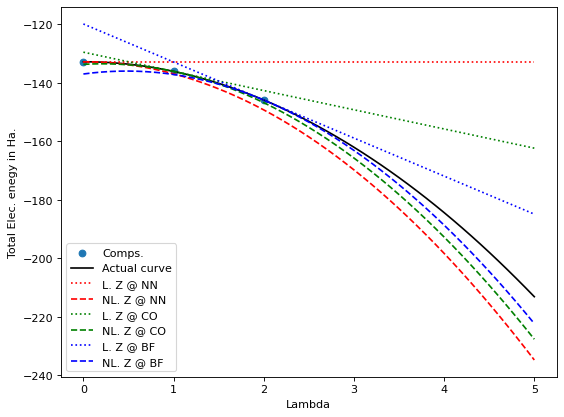

In [143]:
'''Plotting everything'''
frac_energies = np.array(frac_energies)
vals = np.array([np.array(x) for x in [from_NN_l,from_NN_nl, from_CO_l, from_CO_nl,from_BF_l,from_BF_nl]])

keys = ['L. Z @ NN','NL. Z @ NN', 'L. Z @ CO','NL. Z @ CO','L. Z @ BF','NL. Z @ BF']
x_axis = np.linspace(0,5,steps + 1)
lines = dict(zip(keys, vals))
format = ['r:', 'r--', 'g:', 'g--', 'b:', 'b--']

figure(figsize=(8, 6), dpi=80)
plt.scatter([0,1,2],[e_NN, e_CO, e_BF],label='Comps.')
plt.plot(x_axis,np.array(frac_energies),'black',label='Actual curve')

i = 0
for line in lines:
    # plt.scatter(np.linspace(0,2,len(lines[line])),lines[line],label=line)
    plt.plot(x_axis,lines[line],format[i],label=line)
    i +=1
plt.legend()
plt.ylabel('Total Elec. enegy in Ha.')
plt.xlabel('Lambda')
# plt.savefig('main_curve',orientation='portrait')

Text(0, 0.5, 'Error in energy in Ha')

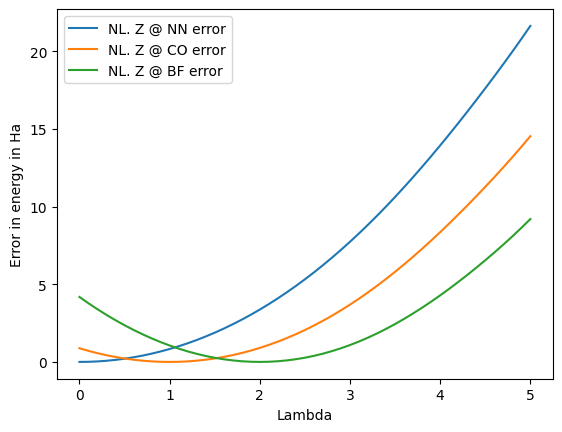

In [121]:
'''Plotting error'''
plt.plot(x_axis, frac_energies - from_NN_nl,label='NL. Z @ NN error')
plt.plot(x_axis, frac_energies - from_CO_nl,label='NL. Z @ CO error')
plt.plot(x_axis, frac_energies - from_BF_nl,label='NL. Z @ BF error')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error in energy in Ha')

#### getting average linearizing coeffecient = ratio of nl_grad to l_grad

In [36]:
def lin_coeff():
    nl_grads= np.array([nl_grad_CO_to_NN, nl_grad_CO_to_BF,
                        nl_grad_BF_to_NN, nl_grad_BF_to_CO])

    l_grads= np.array([l_grad_CO_to_NN, l_grad_CO_to_BF,
                        l_grad_BF_to_NN, l_grad_BF_to_CO])

    # nl_grads = np.append(nl_grads,[nl_grad_NN_to_BF, nl_grad_NN_to_CO])
    # l_grads = np.append(l_grads,[l_grad_NN_to_BF, l_grad_NN_to_CO])
    C = round(np.mean(l_grads / nl_grads),3)

    NN_pred = ['NN','-', e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF]
    CO_pred = ['CO',e_CO + C *nl_grad_CO_to_NN,'-' ,  e_CO + C *nl_grad_CO_to_BF]
    BF_pred = ['BF',e_BF + C *nl_grad_BF_to_NN,e_BF + C *nl_grad_BF_to_CO,'-' ]

    data = [
        ['From \ To', 'NN', 'CO','BF'],
        ['NN',e_NN, e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF],
        ['CO',round(e_CO + C *nl_grad_CO_to_NN,3),e_CO ,  round(e_CO + C *nl_grad_CO_to_BF,3)],
        ['BF',round(e_BF + C *nl_grad_BF_to_NN,3),round(e_BF + C *nl_grad_BF_to_CO,3),e_BF ]
    ]
    table = generate_table(data)
    print('Using average of linearizing coeffecient at CO and BF')
    print()
    print(table)

In [37]:
def nl_grad():
    print('Predictions from NN, CO and BF just using non-linear energy gradient')
    print()
    data = [
        ['From \ To', 'NN','err','CO','err','BF','err'],
        ['NN', e_NN, 0,e_NN + nl_grad_NN_to_CO,round(e_NN + nl_grad_NN_to_CO - e_CO,3),e_NN + nl_grad_NN_to_BF,round(e_NN + nl_grad_NN_to_BF - e_BF,3)],
        ['CO',e_CO + nl_grad_CO_to_NN,round(e_CO + nl_grad_CO_to_NN - e_NN,3),e_CO,0, e_CO + nl_grad_CO_to_BF,round(e_CO + nl_grad_CO_to_BF-e_BF,3)],
        ['BF',e_BF + nl_grad_BF_to_NN,round(e_BF + nl_grad_BF_to_NN - e_NN,3),e_BF + nl_grad_BF_to_CO,round(e_BF + nl_grad_BF_to_CO - e_CO,3),e_BF,0 ]
    ]
    table = generate_table(data)
    print(table)
    print(f'NN actual energy = {e_NN}, \nCO actual energy = {e_CO}, \nBF actual energy = {e_BF}, \n')

In [38]:
def hessian():
    '''Using Hessian'''
    # modelling ax^2 + bx + c
    a = -0.139 - 3.126
    b = 0
    c = -132.748
    def app(l):
        return round(a*l**2 + b*l + c,3)

    print('Prediction of energies via the Hessian')
    print()
    data = [['Mol \ Method', 'Actual (PBE; unc-ccpvdz with RKS)','Hessian from paper','Descrepency'],
            [
                'NN',e_NN, app(0),e_NN-app(0), 
            ],
            [
                'CO',e_CO, app(1),round(e_CO-app(1),3), 
            ],
            [
                'BF',e_BF, app(2),round(e_BF-app(2),3), 
            ]
            
            ]
    table = generate_table(data)
    print(table)

In [39]:
'''Matrix with linear interpolation in Z'''
print('Predictions from NN, CO and BF just using linear Z / non-linear energy gradient')
print()
data = [
    ['From \ To', 'NN','CO','BF'],
    ['NN', e_NN,e_NN + nl_grad_NN_to_CO,e_NN + nl_grad_NN_to_BF],
    ['CO',e_CO + nl_grad_CO_to_NN,e_CO, e_CO + nl_grad_CO_to_BF],
    ['BF',e_BF + nl_grad_BF_to_NN,e_BF + nl_grad_BF_to_CO,e_BF]
]
table = generate_table(data)
print(table)

Predictions from NN, CO and BF just using linear Z / non-linear energy gradient

| From \ To | NN       | CO       | BF       |
| --------- | -------- | -------- | -------- |
| NN        | -132.748 | -132.748 | -132.748 |
| CO        | -129.47  | -136.035 | -142.6   |
| BF        | -119.826 | -132.831 | -145.837 |



In [40]:
'''Matrix with linear interpolation in Z'''
print('Predictions from NN, CO and BF just using non-linear Z / linear energy gradient between pairs')
print()
data = [
    ['From \ To', 'NN','CO','BF'],
    ['NN', e_NN,e_NN + l_grad_NN_to_CO,round(e_NN + l_grad_NN_to_BF,3)],
    ['CO',e_CO + l_grad_CO_to_NN,e_CO, e_CO + l_grad_CO_to_BF],
    ['BF',round(e_BF + l_grad_BF_to_NN,3),e_BF + l_grad_BF_to_CO,e_BF]
]
table = generate_table(data)
print(table)

Predictions from NN, CO and BF just using non-linear Z / linear energy gradient between pairs

| From \ To | NN       | CO       | BF       |
| --------- | -------- | -------- | -------- |
| NN        | -132.748 | -136.868 | -149.21  |
| CO        | -133.628 | -136.035 | -146.739 |
| BF        | -136.931 | -137.093 | -145.837 |



In [76]:
from_BF_l

[-119.826,
 -122.427,
 -125.028,
 -127.629,
 -130.23,
 -132.831,
 -135.433,
 -138.034,
 -140.635,
 -143.236,
 -145.837,
 -148.438,
 -151.039,
 -153.64,
 -156.241,
 -158.843,
 -161.444,
 -164.045,
 -166.646,
 -169.247,
 -171.848]